# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports et nettoyage

### Imports et chemins

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import sys, csv, json

# Racine = dossier parent de notebooks/
PROJECT_ROOT = Path.cwd().resolve().parent
print("📁 Racine projet :", PROJECT_ROOT)

# modules internes
sys.path.insert(0, str(PROJECT_ROOT))

# Fichiers
DATA_CSV   = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR = PROJECT_ROOT / "outputs";  OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

📁 Racine projet : C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ
CSV présent : True - C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\data\processed\final_dataset.csv


### Lecture et nettoyage du jeu de données

In [2]:
df = pd.read_csv(
    DATA_CSV,
    parse_dates=["date", "closed_at", "cve_pub"],
    keep_default_na=False
).replace({"n/a": np.nan, "": np.nan})

# Types numériques explicites
num_cols = ["cvss_score", "epss_score", "epss_percentile", "lag_anssi_days"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Explosion des versions (facultatif mais utile)
df = df.explode("versions")

# Dédoublonnage
df = df.drop_duplicates(subset=["cve", "vendor_std", "produit", "versions"])

# Sous-ensemble sûr pour graphiques existants
df_visu = (df.dropna(subset=["cvss_score", "epss_score"]).copy())
df_unique = df.drop_duplicates(subset=["cve"]).copy()

print("✅ Dataset nettoyé :", df_visu.shape)

✅ Dataset nettoyé : (33035, 22)


## Gravité et risques d'exploitation

### Scatter « CVSS × EPSS »

Nous cherchons à identifier des vulnérabilités à la fois graves ET probables, soit celles situées dans le quart supérieur droit du graphique.

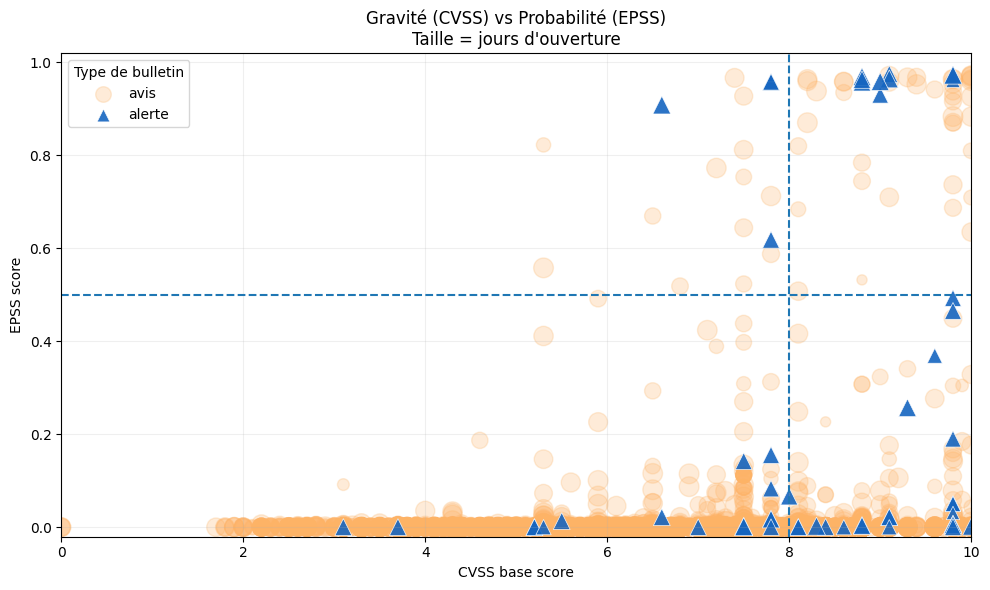

51 urgences enregistrées → C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\outputs\urgences_cve.csv


In [3]:
# 1. Filtrage des scores valides uniquement (sans redédupliquer)
df_visu_unique = df_unique.dropna(subset=["cvss_score", "epss_score"]).copy()

# 2. Calcul de la taille des points (logarithme des jours d'ouverture)
df_visu_unique["size_pt"] = np.log1p(df_visu_unique["days_open"]).fillna(0) * 30

# 3. Création du nuage de points
plt.figure(figsize=(10, 6))

# Avis
sub_avis = df_visu_unique[df_visu_unique["type"] == "avis"]
plt.scatter(sub_avis["cvss_score"], sub_avis["epss_score"],
            s=sub_avis["size_pt"], c="#FDB366", alpha=0.25,
            label="avis", marker="o")

# Alertes
sub_ale = df_visu_unique[df_visu_unique["type"] == "alerte"]
plt.scatter(sub_ale["cvss_score"], sub_ale["epss_score"],
            s=sub_ale["size_pt"], c="#1565C0", alpha=0.9,
            label="alerte", marker="^", edgecolors="white", linewidths=0.5)

plt.axvline(8, linestyle="--")
plt.axhline(0.5, linestyle="--")
plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)\nTaille = jours d'ouverture")
plt.xlim(0, 10)
plt.ylim(-0.02, 1.02)
plt.legend(title="Type de bulletin")
plt.grid(alpha=.2)
plt.tight_layout()
plt.show()

# 4. Export des CVE urgentes (quart supérieur droit)
urg = df_visu_unique[(df_visu_unique["cvss_score"] >= 8) & (df_visu_unique["epss_score"] >= 0.5)]
urg.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urg)} urgences enregistrées → {OUTPUT_DIR/'urgences_cve.csv'}")


Parmi les points situés dans la zone critique, nous observons plusieurs vulnérabilités qui cumulent :
* CVSS très élevé (souvent 9 à 10)
* EPSS proche de 1 : les failles sont hautement exploitables
* `days_open` très élevés pour certaines failles ce qui montre une exposition prolongée
* Des vulnérabilités publiées dans des produits critiques : Microsoft, Ivanti, GitLab, Cisco, SAP, Atlassian, etc.

Ces points sont donc nos urgences absolues : score technique élevé ET probabilité d’exploitation réelle. Cela permet également de montrer par exemple qu'une faille avec CVSS 10 mais EPSS 0.01 n’est pas forcément prioritaire (faible exploitation en pratique). Tandis qu'une faille à CVSS 7.5 mais EPSS 0.95 peut être plus risquée sur le terrain.

Le fait que Microsoft, Ivanti, Cisco, Atlassian ressortent régulièrement sont des indicateurs d'exposition. En effet, les produits concernés couvrent aussi bien OS, outils DevOps, sécurité, bases de données...

On peut ainsi distinguer le profil des alertes à envoyer en toutes circonstances si elles réunissent ces critères.

### Histogramme empilé des scores CVSS

On cherche ici à analyser la distribution des niveaux de gravité CVSS (Common Vulnerability Scoring System) des vulnérabilités documentées dans les bulletins avis et alertes de l’ANSSI. On peut ainsi visualiser les plages de gravité les plus fréquentes et identifier les zones critiques (CVSS ≥ 7, 8 ou 9), souvent associées à des failles exploitables ou très graves.

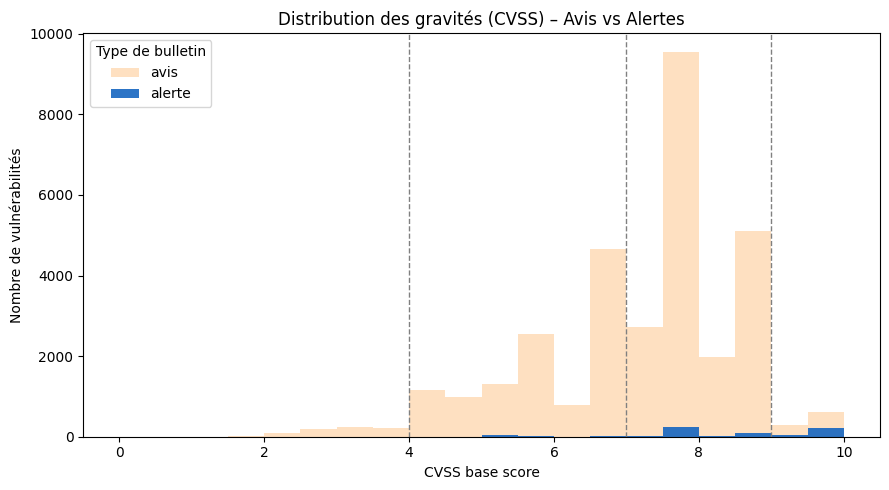

In [4]:
# 1. Sélection des scores valides
avis_cvss     = df[df["type"] == "avis"]["cvss_score"].dropna()
alertes_cvss  = df[df["type"] == "alerte"]["cvss_score"].dropna()

# 2. Bins 0 → 10 par pas de 0.5
bins = np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9, 5))

# 1. Avis en premier
plt.hist(
    avis_cvss,
    bins=bins,
    color="#FDB366",
    alpha=0.4,
    label="avis",
)

# 2. Alertes par-dessus
plt.hist(
    alertes_cvss,
    bins=bins,
    color="#1565C0",
    alpha=0.9,
    label="alerte",
    stacked=True  # pas indispensable ici, mais garde le même rendu
)

# seuils CVSS
for x in (4, 7, 9):
    plt.axvline(x, linestyle="--", color="grey", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Distribution des gravités (CVSS) – Avis vs Alertes")
plt.legend(title="Type de bulletin")
plt.tight_layout()
plt.show()

On remarque clairement que les bins de 5.0 à 7.0 regroupent une très grande proportion des vulnérabilités (plus de 11 000). Un pic net dans le bin [7.5–8.0[ avec 9780 vulnérabilités (dont 236 alertes).

Les avis représentent la majorité des enregistrements, ce qui reflète le rôle de l’ANSSI dans la veille large. Toutefois, les alertes, bien que minoritaires, apparaissent massivement dans les scores les plus élevés.

La zone critique (CVSS ≥ 9.0) contient un total de 1173 vulnérabilités, dont 260 alertes. Cela montre que plus de 22% des vulnérabilités très graves font l’objet d’alertes, bien plus que dans les autres bins.

Pour la suite de notre projet, cette visualiation montre que les bins supérieurs (≥ 8.0) doivent faire l’objet d’un suivi renforcé. Un focus sur les alertes dans cette plage permet de filtrer les CVE les plus urgentes. Aussi, le fait que les alertes soient concentrées dans les scores élevés confirme la stratégie de publication ciblée de l’agence.

### Violin plot EPSS par quartile CVSS

On cherche ici à savoir si les vulnérabilités les plus graves (CVSS élevé) sont aussi les plus susceptibles d’être exploitées (EPSS élevé). Cette visualisation permet donc de voir la densité des valeurs EPSS dans chaque groupe CVSS (Q1 à Q4), et d’observer leur dispersion, asymétrie, et tendance centrale.

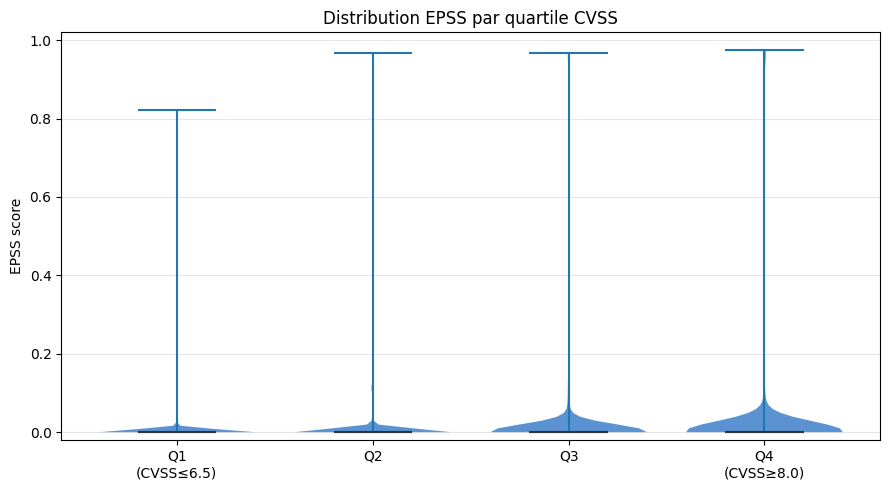

In [5]:
# 1. Conserver uniquement lignes scorées
d = df.dropna(subset=["cvss_score", "epss_score"]).copy()

# 2. Quartiles basés sur la distribution CVSS
d["cvss_quartile"] = pd.qcut(d["cvss_score"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# 3. Préparer les données pour le violin plot
grouped_epss = [d[d["cvss_quartile"] == q]["epss_score"] for q in ["Q1", "Q2", "Q3", "Q4"]]

plt.figure(figsize=(9, 5))
parts = plt.violinplot(
    grouped_epss,
    showmeans=False,
    showmedians=True,
    widths=0.8
)

# 4. Esthétique basique
for pc in parts["bodies"]:
    pc.set_facecolor("#1565C0")
    pc.set_alpha(0.7)

median_color = "#333333"
parts["cmedians"].set_color(median_color)

quartile_labels = [
    f"Q1\n(CVSS≤{d['cvss_score'].quantile(0.25):.1f})",
    "Q2",
    "Q3",
    f"Q4\n(CVSS≥{d['cvss_score'].quantile(0.75):.1f})",
]

plt.xticks(
    ticks=[1, 2, 3, 4],
    labels=quartile_labels
)
plt.ylabel("EPSS score")
plt.title("Distribution EPSS par quartile CVSS")
plt.ylim(-0.02, 1.02)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

On remarque que la majorité des vulnérabilités, quel que soit le quartile CVSS, ont un score EPSS très faible. Toutefois, on observe une augmentation progressive de la dispersion EPSS au fil des quartiles. Entre autres, le quartile Q4 (CVSS ≥ 8.0) montre une queue plus étendue vers les scores EPSS élevés, ce qui confirme visuellement que les vulnérabilités les plus graves sont aussi celles qui ont le plus de chances d’être exploitées, bien que cela reste marginal à l’échelle globale.

Cela confirme donc bien l’intérêt de croiser CVSS et EPSS car se baser uniquement sur la gravité (CVSS) néglige la faible exploitabilité de la majorité des vulnérabilités.

### Courbe cumulative des vulnérabilités en fonction du temps

Montrer l’évolution temporelle du nombre de vulnérabilités détectées

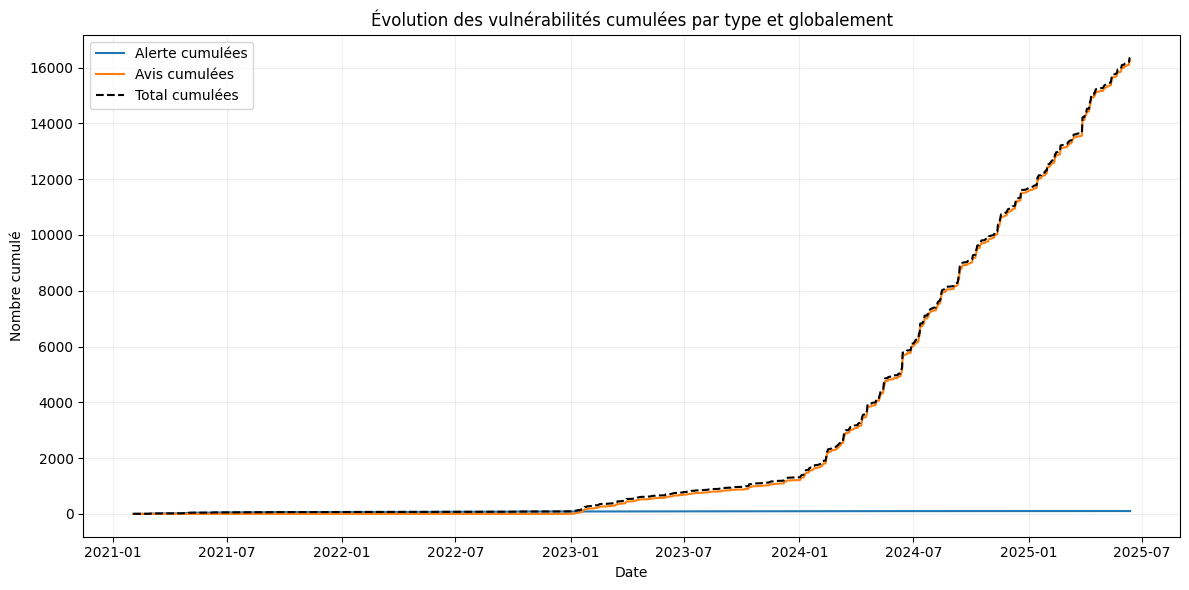

In [6]:
plt.figure(figsize=(12, 6))

# 1. Regrouper par date et type (df_unique contient déjà 1 ligne par CVE)
vuln_cum_par_type = (
    df_unique.groupby(["date", "type"])
             .size()
             .unstack(fill_value=0)
             .sort_index()
             .cumsum()
)

# 2. Tracer les courbes par type
for col in vuln_cum_par_type.columns:
    plt.plot(
        vuln_cum_par_type.index,
        vuln_cum_par_type[col],
        label=f"{col.capitalize()} cumulées"
    )

# 3. Courbe cumulée globale (total sans distinction de type)
vuln_cum_total = (
    df_unique.groupby("date")
             .size()
             .sort_index()
             .cumsum()
)

plt.plot(
    vuln_cum_total.index,
    vuln_cum_total.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulé")
plt.title("Évolution des vulnérabilités cumulées par type et globalement")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### Stacked Area :

Total des vulnérabilités vs subsets "CVSS >= 8 et EPSS >= 0.5" : **Suit l'évolution du "backlog critique"**

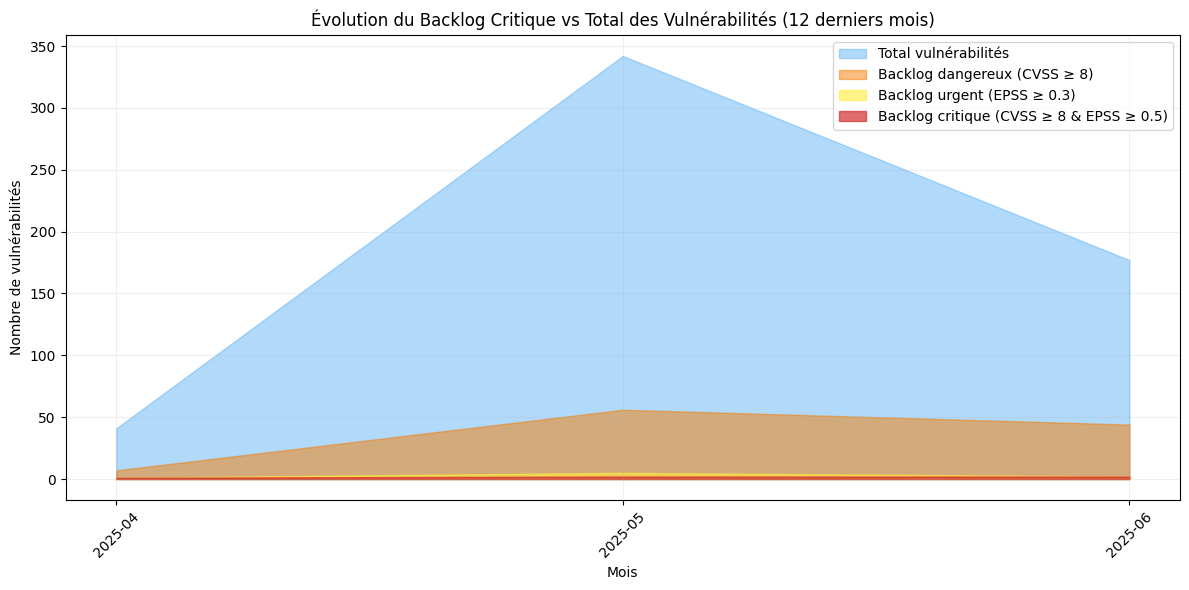

In [53]:
# Filtrer les CVE avec des scores valides
df_valid_scores = df_unique.dropna(subset=["cvss_score", "epss_score"]).copy()

# Définir la date limite (12 mois avant aujourd’hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=2)

# Filtrer dans df_valid_scores (CVE dédupliquées)
df_recent = df_valid_scores[df_valid_scores["date"] >= date_limite].copy()

# Regrouper par mois
df_recent["month"] = df_recent["date"].dt.to_period("M")

# Total CVE par mois
monthly_total = df_recent.groupby("month").size()

# Subset dangereux
danger = df_recent[(df_recent["cvss_score"] >= 8)]
monthly_danger = danger.groupby("month").size()

# Subset urgent (EPSS ≥ 0.3)
urgent = df_recent[(df_recent["epss_score"] >= 0.3)]
monthly_urgent = urgent.groupby("month").size()

# Subset critique
critical = df_recent[(df_recent["cvss_score"] >= 8) & (df_recent["epss_score"] >= 0.3)]
monthly_critical = critical.groupby("month").size()


# Aligner les index
all_months = monthly_total.index.union(monthly_critical.index).sort_values()
monthly_total = monthly_total.reindex(all_months, fill_value=0)
monthly_danger = monthly_danger.reindex(all_months, fill_value=0)
monthly_urgent = monthly_urgent.reindex(all_months, fill_value=0)
monthly_critical = monthly_critical.reindex(all_months, fill_value=0)


# Tracé Stacked Area
plt.figure(figsize=(12, 6))
plt.fill_between(all_months.astype(str), monthly_total.values, color="#64B5F6", alpha=0.5, label="Total vulnérabilités")
plt.fill_between(all_months.astype(str), monthly_danger.values, color="#F57C00", alpha=0.5, label="Backlog dangereux (CVSS ≥ 8)")
plt.fill_between(all_months.astype(str), monthly_urgent.values, color="#FFEB3B", alpha=0.6, label="Backlog urgent (EPSS ≥ 0.3)")
plt.fill_between(all_months.astype(str), monthly_critical.values, color="#D32F2F", alpha=0.7, label="Backlog critique (CVSS ≥ 8 & EPSS ≥ 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités (12 derniers mois)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Peut-être modifier la fenêtre temporelle

### Boxplot des scores CVSS par éditeur

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 1200x600 with 0 Axes>

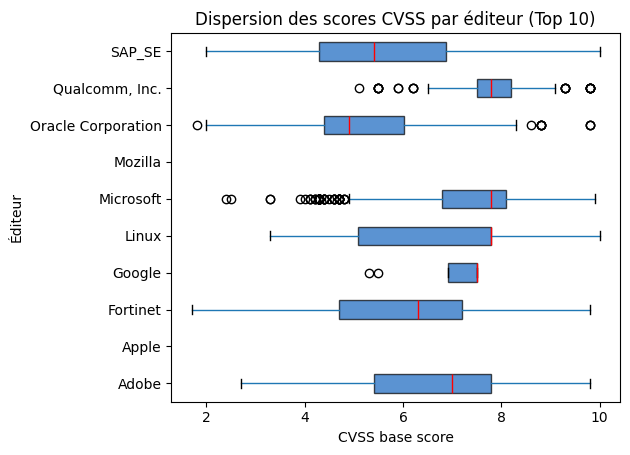

In [8]:
plt.figure(figsize=(12, 6))

# Top 10 éditeurs selon le nombre de CVE uniques
top_vendors = df_unique["vendor"].value_counts().head(10).index
subset_top_vendors = df_unique[df_unique["vendor"].isin(top_vendors)]

# Boxplot horizontal
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False
)

plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # Supprime le titre automatique
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()


## Dimensions techniques

### Top 15 des faiblesses (CWE)

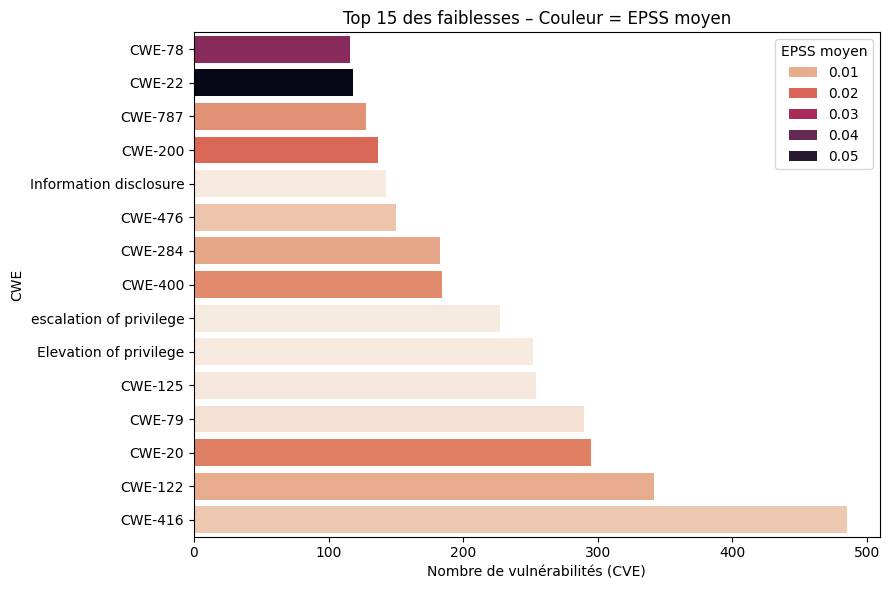

In [9]:
# 1) filtrer lignes disposant d’un CWE
d_cwe = df_unique.dropna(subset=["cwe"])

# 2) agrégation : nombre de CVE et EPSS moyen
top_cwe = (
    d_cwe.groupby("cwe", as_index=False)
         .agg(nb=("cwe", "size"),
              epss_moy=("epss_score", "mean"))
         .sort_values("nb", ascending=False)
         .head(15)
         .sort_values("nb")          # pour plot horizontal ascendant
)

# 3) barplot horizontal, palette graduée sur l’EPSS moyen
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_cwe,
    x="nb",
    y="cwe",
    hue="epss_moy",
    palette="rocket_r",
    dodge=False
)

plt.xlabel("Nombre de vulnérabilités (CVE)")
plt.ylabel("CWE")
plt.title("Top 15 des faiblesses – Couleur = EPSS moyen")
plt.legend(title="EPSS moyen", loc="upper right")
plt.tight_layout()
plt.show()

### Diagramme circulaire des types de vulnérabilités (CWE)

Pour comparer les catégories de faiblesses les plus fréquentes par rapport aux autre vulnérabilités.

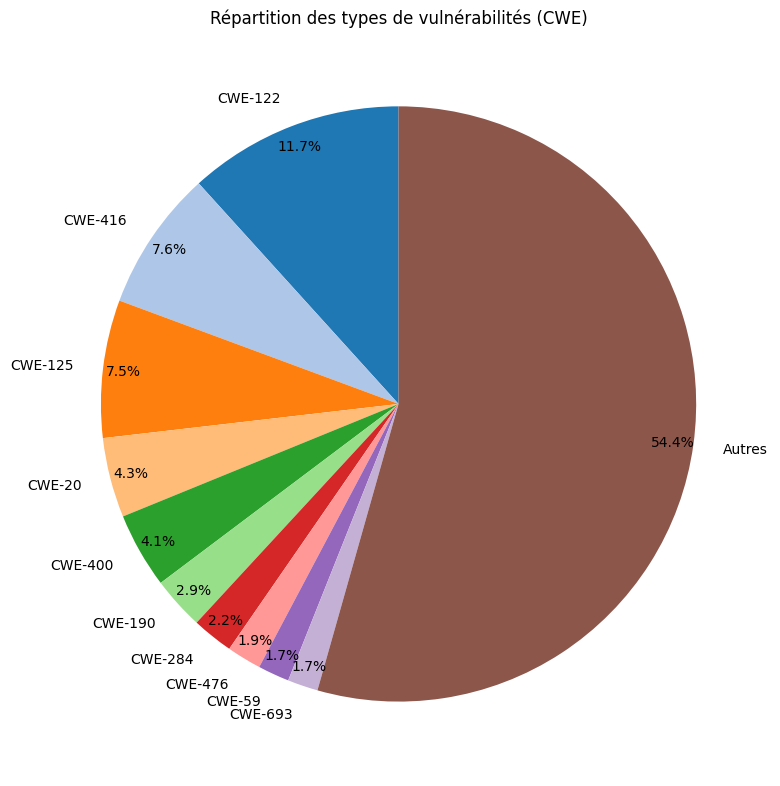

In [10]:
# Filtrer les lignes disposant d’un CWE
d_cwe = df.dropna(subset=["cwe"])

# Calculer les occurrences pour chaque CWE
cwe_counts = d_cwe["cwe"].value_counts()

# Identifier le top 20 des CWE
top_20_cwe = cwe_counts.head(10)

# Calculer les occurrences des autres CWE
others_count = cwe_counts.iloc[10:].sum()

# Préparer les données pour le diagramme circulaire
pie_data = pd.concat([top_20_cwe, pd.Series({"Autres": others_count})])

# Tracer le diagramme circulaire avec les pourcentages à l'extérieur
plt.figure(figsize=(8, 8))
plt.pie(
    pie_data,
    labels=pie_data.index,
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=0.93,
    colors=sns.color_palette("tab20", len(pie_data))
)
plt.title("Répartition des types de vulnérabilités (CWE)")
plt.tight_layout()
plt.show()

### Courbe de l'évolution de différent CWE au cours du temps

Permet d'observer l'évolution d'un type de CWE

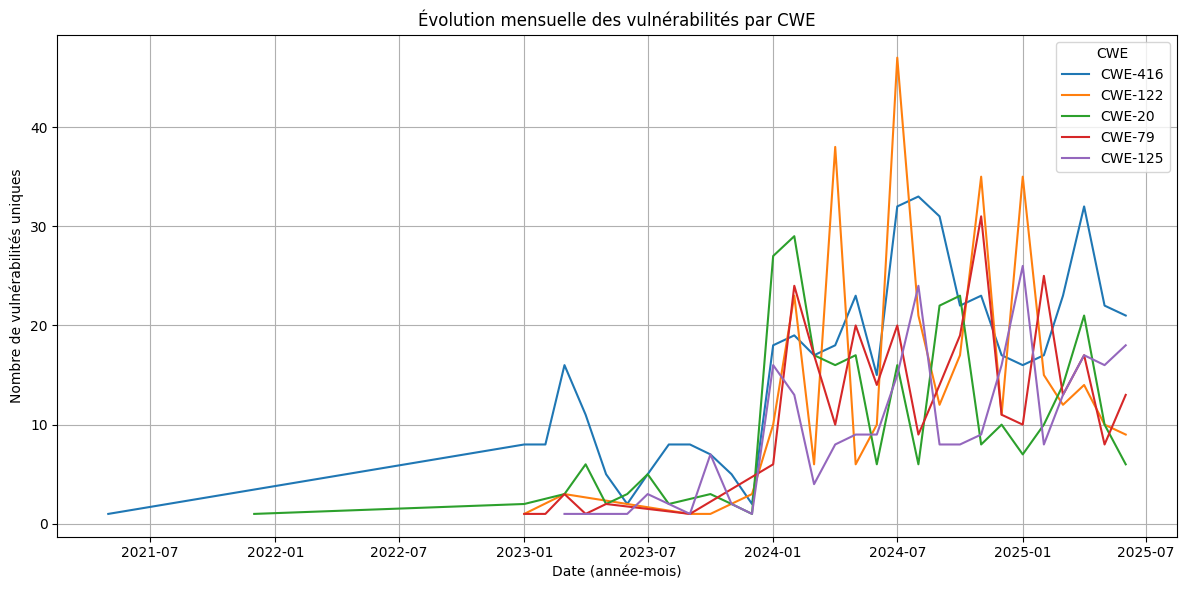

In [11]:
cwe_list = ["CWE-416", "CWE-122", "CWE-20", "CWE-79", "CWE-125"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df_unique[df_unique["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l’année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités uniques")
plt.legend(title="CWE")
plt.grid(True)
plt.tight_layout()
plt.show()


### Heat-map Vendor × CWE

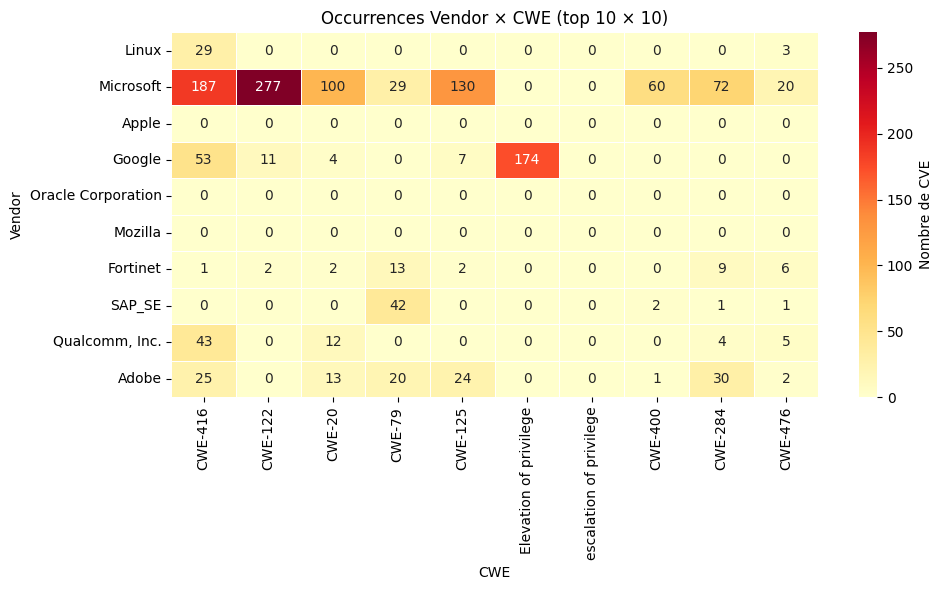

In [12]:
# 1) périmètre raisonnable : top 10 vendors & top 10 CWE
top_vendors = df_unique["vendor"].value_counts().head(10).index
top_cwes    = df_unique["cwe"].value_counts().head(10).index

sub = df_unique[df_unique["vendor"].isin(top_vendors) & df_unique["cwe"].isin(top_cwes)]

# 2) matrice Vendor × CWE
pivot = (
    sub.groupby(["vendor", "cwe"])
       .size()
       .unstack(fill_value=0)
)

# 3) forcer l’ordre ET compléter les manquants avec 0
pivot = pivot.reindex(index=top_vendors, columns=top_cwes, fill_value=0)

# 4) tracé heat-map
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True, fmt="d", linewidths=.5,
    cmap="YlOrRd", cbar_kws={"label": "Nombre de CVE"}
)
plt.title("Occurrences Vendor × CWE (top 10 × 10)")
plt.xlabel("CWE")
plt.ylabel("Vendor")
plt.tight_layout()
plt.show()

### Treemap Bulletins, pour la taille d'impact des bulletins

Déniche les bulletins "massifs", parfois sous-estimés


In [13]:
import plotly.express as px

# Définir la date limite (6 mois avant aujourd'hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=4)

# Calcul le nombre de produits affectés par CVE
df["n_affected_products"] = df["versions"].apply(lambda x: len(str(x).split("|")) if pd.notnull(x) else 0)

# Filtre pour les 100 plus impactants
top_50_alertes_avis = df[df["type"].isin(["alerte", "avis"])].nlargest(200, "n_affected_products")

# Filtrer les bulletins récents
bulletins_recents = top_50_alertes_avis[top_50_alertes_avis["date"] >= date_limite]

# Agrégation pour la treemap
treemap_data = bulletins_recents.groupby(["type", "id_anssi", "date"]).agg(
    n_affected_products=("n_affected_products", "sum"),
    titre=("titre", "first")
).reset_index()


treemap_data = treemap_data.sort_values(by="n_affected_products", ascending=False)


# Créer une treemap avec plotly.express
fig = px.treemap(
    treemap_data,
    path=["type", "date","id_anssi", "titre"],
    color="n_affected_products",
    values="n_affected_products",
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data['n_affected_products'], weights=treemap_data['n_affected_products'])
)

fig.update_layout(
    title="Treemap Bulletins - Taille d'impact des bulletins",
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()

### CVE / an pour les 5 éditeurs majeurs

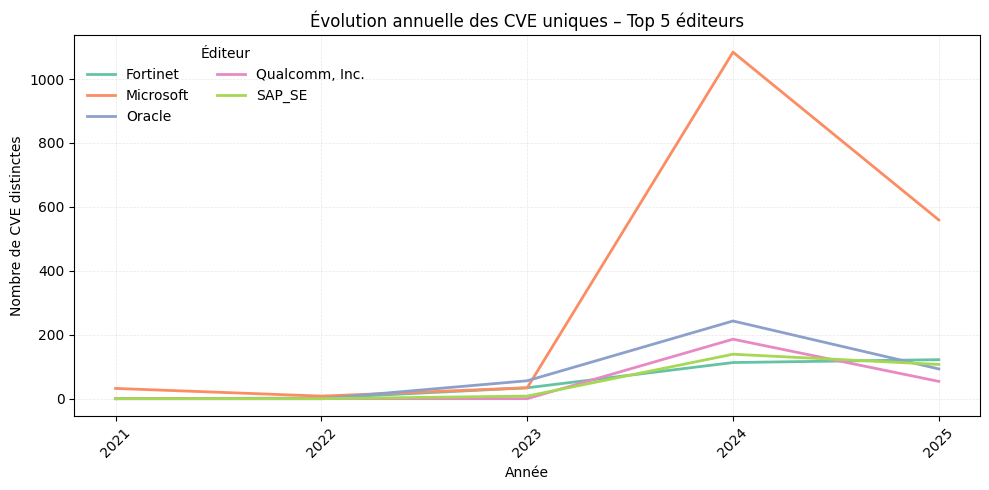

In [14]:
# ─── 0. Pré-filtre : une seule ligne (vendor, cve, year) ───────────────
clean = (
    df_visu
      .dropna(subset=["vendor_std", "date", "cve"])
      .assign(year=lambda d: d["date"].dt.year)
      .drop_duplicates(subset=["vendor_std", "cve"])   # ⇦ clé anti-doublon
)

# ─── 1. Top-5 éditeurs sur l’ensemble de la période ────────────────────
top5 = (
    clean["vendor_std"]
         .value_counts()
         .head(5)
         .index
)

# ─── 2. Comptage annuel distinct (CVE uniques) ─────────────────────────
pivot = (
    clean[clean["vendor_std"].isin(top5)]
        .groupby(["year", "vendor_std"])
        .size()
        .unstack(fill_value=0)         # lignes = années, colonnes = vendors
        .sort_index()
)

# ─── 3. Compléter années manquantes (0) ────────────────────────────────
full_years = pd.RangeIndex(pivot.index.min(), pivot.index.max() + 1)
pivot = pivot.reindex(full_years, fill_value=0)

# ─── 4. Tracé multi-séries ─────────────────────────────────────────────
import matplotlib.pyplot as plt, seaborn as sns

plt.figure(figsize=(10, 5))
palette = sns.color_palette("Set2", n_colors=len(top5))

for i, vendor in enumerate(pivot.columns):
    plt.plot(pivot.index, pivot[vendor],
             label=vendor, color=palette[i], linewidth=2)

plt.title("Évolution annuelle des CVE uniques – Top 5 éditeurs")
plt.xlabel("Année");  plt.ylabel("Nombre de CVE distinctes")
plt.xticks(pivot.index, rotation=45)
plt.grid(alpha=.3, linestyle="--", linewidth=.5)
plt.legend(title="Éditeur", ncol=2, frameon=False)
plt.tight_layout();  plt.show()

### Scatter Nombre de références avec EPSS : Attention il faudrait récupérer les données n_cve_refs

Evalue la popularité/médiatisation. Plus de sources implique un risque médiatique et une exploitation probable

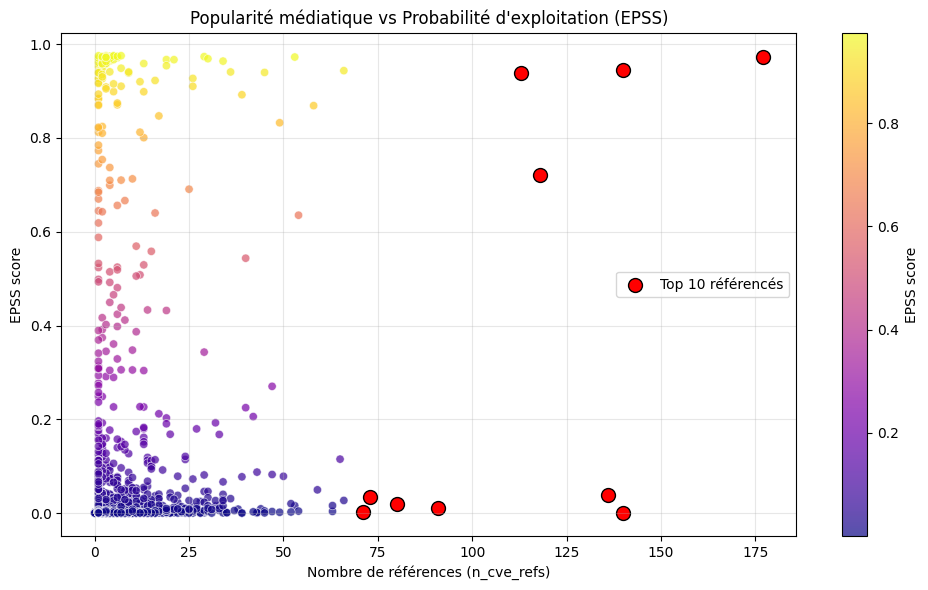

Top 10 des cas les plus référencés :
╒════════╤════════════════╤══════════════╤══════════════╤══════════════╤════════════╕
│        │ cve            │   n_cve_refs │   epss_score │   cvss_score │ cvss_sev   │
╞════════╪════════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ 128657 │ CVE-2014-6271  │          177 │      0.97214 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│   5851 │ CVE-2023-44487 │          140 │      0.94434 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  73037 │ CVE-2020-27216 │          140 │      0.00074 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  10260 │ CVE-2016-2183  │          136 │      0.03984 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  10201 │ CVE-20

In [19]:
from tabulate import tabulate

# Trier les données par le nombre de références (n_cve_refs) en ordre décroissant
top_referenced_cases = df_unique.nlargest(10, "n_cve_refs").copy()

# Mettre en évidence ces cas dans le graphique
plt.figure(figsize=(10, 6))

# Tracé du nuage de points
scatter = plt.scatter(
    df_unique["n_cve_refs"],
    df_unique["epss_score"],
    c=df_unique["epss_score"],  # Utiliser les scores EPSS pour la couleur
    alpha=0.7,
    edgecolors="white",
    cmap="plasma",
    linewidths=0.5
)

# Ajouter les cas top 10 avec une couleur différente
plt.scatter(
    top_referenced_cases["n_cve_refs"],
    top_referenced_cases["epss_score"],
    color="red",
    edgecolors="black",
    label="Top 10 référencés",
    s=100
)

# Ajouter une barre de couleur
plt.colorbar(scatter, label="EPSS score")

plt.xlabel("Nombre de références (n_cve_refs)")
plt.ylabel("EPSS score")
plt.title("Popularité médiatique vs Probabilité d'exploitation (EPSS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher le tableau complémentaire

print("Top 10 des cas les plus référencés :")
print(tabulate(
    top_referenced_cases[["cve", "n_cve_refs", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid"
))

## **Résultats du modèle de classification (Random Forest)**

Nous avons entraîné un modèle de type Random Forest pour prédire la gravité (cvss_sev) d’une vulnérabilité à partir de plusieurs variables : le score CVSS, le score EPSS, le percentile EPSS et le nombre de jours depuis la publication (days_open).

Les résultats obtenus sont très bons. Le rapport de classification montre une précision, un rappel et un score F1 de 1.00 pour les classes principales : CRITICAL, HIGH, MEDIUM et LOW. Seule la classe NONE est un peu moins bien prédite. Cela s’explique par le fait qu’elle ne contient que deux exemples dans l’ensemble de test, ce qui rend l’évaluation peu représentative.

La matrice de confusion confirme ces performances. Le modèle classe correctement presque toutes les observations. On observe une seule confusion entre la classe LOW et NONE, ce qui est négligeable par rapport au nombre total d’exemples.

**Interprétation des résultats**

Ces résultats montrent que le modèle est capable de prédire de manière fiable la gravité d’une vulnérabilité, même lorsqu’elle n’est pas fournie directement. Les variables utilisées sont suffisamment informatives pour permettre une bonne séparation entre les classes.

Cela est très utile dans notre projet, car certaines vulnérabilités ne sont pas toujours accompagnées d’un niveau de gravité clair. Grâce à ce modèle, nous pouvons estimer ce niveau automatiquement.

**Utilité pour la suite du projet**

L’intégration de ce modèle dans notre pipeline permet de renforcer le système de détection des vulnérabilités critiques. Lorsqu’une faille est prédite comme critique par le modèle, même si elle n’est pas encore officiellement classée, une alerte peut être déclenchée.

Par exemple, si une CVE présente un score EPSS élevé mais n’a pas encore de gravité assignée, le modèle peut prédire qu’elle est critique. Cela permet d’envoyer une notification sans attendre les mises à jour officielles.

## **Résultats du modèle de regroupement (KMeans)**

Nous avons utilisé l’algorithme KMeans pour regrouper les vulnérabilités en fonction de leurs caractéristiques, sans utiliser d’étiquette de gravité. C’est une méthode non supervisée, qui cherche à créer des groupes d’éléments similaires.

Avant d’appliquer le modèle, nous avons réduit le nombre de dimensions grâce à une analyse en composantes principales (PCA). Cela permet de visualiser les données sur un graphique en deux dimensions.

Le graphique obtenu montre plusieurs groupes bien distincts. Chaque couleur représente un groupe (ou cluster) de vulnérabilités qui partagent des caractéristiques communes.
Interprétation des résultats

Les résultats montrent que les vulnérabilités peuvent être classées automatiquement en différents groupes. Chaque groupe contient des vulnérabilités qui se ressemblent :
- Un groupe peut contenir des vulnérabilités très graves, avec un score élevé et un fort risque d’exploitation.
- Un autre groupe peut regrouper des failles moins graves ou plus anciennes.
- Certains groupes sont très compacts (vulnérabilités très similaires), d'autres plus dispersés (vulnérabilités plus variées).

Cela permet de mieux comprendre les types de vulnérabilités présents dans les données.

**Utilité pour le projet**

Ce modèle est très utile pour notre projet. Il nous permet de :
classer automatiquement les vulnérabilités, même quand nous ne connaissons pas encore leur gravité, d'identifier les groupes les plus à risque, pour mieux prioriser les actions à mener, et enfin repérer des anomalies, c’est-à-dire des failles qui ne ressemblent à aucune autre.

Par exemple, si un groupe contient souvent des vulnérabilités critiques, alors toutes les nouvelles failles qui entrent dans ce groupe doivent être surveillées de près.